In [2]:
import math

##### Wrapper class for building chained math expressions in the demonstration (based on Andrej Karpathy's Micrograd) #####
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # store the gradient/derivative with respect to L, to start we assume every value has no effect on the output (0)
        # back prop using chain rule
        self._backward = lambda: None # initialize to nothing - by default do nothing. Ex: For a leaf node like the bias there is nothing to calculate
        # store the children when math expressions are run on this value instance
        self._prev = set(_children) # ? set is probably just for efficiency
        self._op = _op # math operation stored that was run
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # convenience to convert ints or floats to Value if passed in. allows usage: a + 1
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            '''chain local derivative with global derivative of output L with respect to out'''
            # out.grad is essentially copied to self and other - this happens with an addition operation
            # out is captured in a closure
            self.grad += 1.0 * out.grad # the local derivative - must be accumulated with the `+=` operator. TODO: ? try to understand the reason for this better
            other.grad += 1.0 * out.grad
        
        out._backward = _backward # store the function so you can call it later during back propagation process
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') # pass in children (this is working towards allowing chaining operations and keeping track of an expression graph)
        
        def _backward():
            # chain out.grad into self.grad and other.grad - typical of multiplication operation
            self.grad += other.data * out.grad # the chain rule
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):
        '''Overwrite exponent function. Adds back prop method'''
        assert isinstance(other, (int, float)), "only support int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            local_derivative = other * (self.data ** (other - 1)) # Power rule to get the derivative of x^n -> d/dx(x^n) = nx^-1 where n is other(the exponent) and x is self.data
            self.grad = local_derivative * out.grad # chain rule
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        # builtin python fallback to allow for running expressions in reverse like 2 * a (2.__mul__() will fail otherwise trying to multiply with a Value() instance)
        return self * other # 2 * a will become a * 2 when first order fails due to reversal behavior builtin
    
    def __truediv__(self, other):
        return self * other**-1 # equivalent of dividing: a * b^-1 = a * 1/b = a / b 
    
    def __neg__(self):
        return self * -1 # overwrite negation by multiplying the number by -1 (why do we need to do this and not just use native negation?)
    
    def __sub__(self, other):
        return self + (-other) # reuses addition overwrite impl
    
    def tanh(self):
        '''Squashing function in a neuron'''
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh') # just store self as the child - this just runs on the current data value without input
        
        def _backward():
            # we have the gradient for self already so chain out.grad into self.grad
            # self.grad is the local derivative of the operation here (tanh)
            local_derivative = 1 - t**2 # t is the tanh output
            self.grad += local_derivative * out.grad # chain rule - product of the derivatives

        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp') # children is just self, there is no other number in this operation
    
        def _backward():
            self.grad = out.data * out.grad # ? TODO: what is the reasoning behind how the chain rule is applied here to e^x?
        out._backward = _backward

        return out
    
    def backward(self):
        '''
        Call backward propogation to chain gradients of all nodes in the expression graph.
        Usage: `node.backward()` where `node` is the last node in a expression graph.
        ex: `o.backward()`
        '''
        # This lays out a list of all the nodes in the graph from left to right (o the final output is the last node in the list)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v) # mark as visited
                for child in v._prev: # iterate through node's children
                    build_topo(child)
                topo.append(v) # AFTER iterating through all children, add self to the main list
                # this gaurantees that the node is added to the list only after all of its children are in the list first
        build_topo(self) # start at the end output node `o` of the graph

        self.grad = 1.0 # initialize gradient of (final) output node in the graph to 1.0 since it is 0 when Value is instantiated
        for node in reversed(topo):
            node._backward()

In [3]:
a = Value(2.0)
b  = Value(4.0)
a / b

Value(data=0.5)

In [4]:
# Subtle bug if re-using terms (Value instance) that leads to overwriting the .grad property if
# See Multivariable case of the chain rule for explanation: https://en.wikipedia.org/wiki/Chain_rule
# Test to make sure that gradients are cumulative and not overridden, but added (self.grad +=)
   
a = Value(-2.0, label='a')
b = a + a # use the same term more than once, `other.grad = ...` in `__add__(self,other)`, for example, overwrites value with 1 during backpropagation since self and other are the same node object
b.backward()

assert a.grad != 1.0 # a.grad should not be overwritten during back propagation when called a second time
assert a.grad == 2.0 # the derivative of b with respect to a is 2 (the derivatives of a+a or 1 + 1)

print('PASSED Test: gradients are not overwritten when same term is used more than once during back propagation')


PASSED Test: gradients are not overwritten when same term is used more than once during back propagation


In [6]:
# for displaying back propagation visualization

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Value(data=2.0)
Value(data=-1.0)
Value(data=-6.0)
Value(data=4.0)
children: {Value(data=10.0), Value(data=-6.0)}
operation: +
Value(data=-8.0)


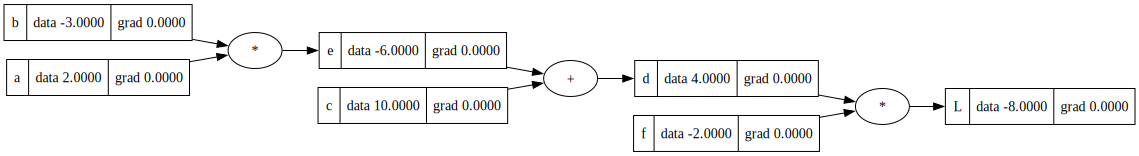

In [7]:
#### First pass using Value - defining and chaining an expression for manual back propagation demo

print(Value(2.0)) # just wraps a value that is passed in

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
print(a+b)
print(a*b)

e = a*b; e.label='e'
d = e + c; d.label='d'
print(d)
print(f'children: {d._prev}')
print(f'operation: {d._op}')

f = Value(-2.0, label='f')
# output of graph:
L = d * f; L.label='L'
print(L)

##### FORWARD PASS

draw_dot(L) # The output of the forward-pass is -8 here. All gradients start at 0.0

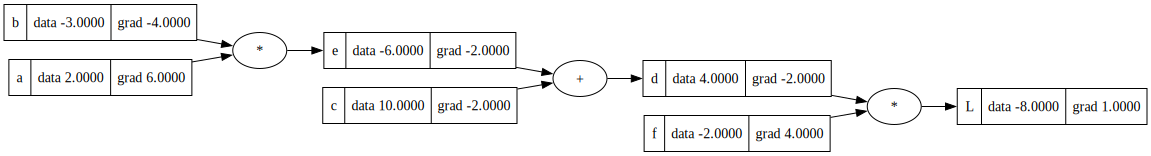

In [8]:
########################################################
#
#              BACK PROPAGATION (Manual Demo)
#
########################################################

# Start at the end (L) and reverse calculate the gradient at all of the intermediate values
  # Compute the derivate of the value of each node with respect to L
  # Ex: the derivative of L with respect to L is just 1, get derivate of L with respect to f, with respect to d, etc..
# We're interested in the derivative of this loss function L, with respect to the weights of the neural network
  # the goal is to know how weights are impacting the loss function 
  #   #(interested in the derivative of the output with respect to some of its leaf nodes/weights)
      # other leaf nodes will be the data itself that we won't want to use because the data is fixed and not parameters/variable


# Set the base gradient which is 1 for the output of L (whatever we increase L by, the output increases the same amount)
L.grad = 1

# get derivatives of L with respect to d and f (they are f and d respectively)
f.grad = 4.0 # value of d
d.grad = -2.0 # value of f

#########################
#
#      CHAIN RULE
#
#########################

### Now to find how c impacts L, you need to know how c impacts d and how d impacts L (which we know) and put that information together to get an idea of how c affects L

# Use the CHAIN RULE from Calculus: dz/dx = dz/dy * dy/dz
  # z depends on y, and y depends on x (one step from z via y) - similar to how c and e are one step from L via d in our expression graph
  # The product of the two rates of change (z to y and y to x) will give the rate of change of z with respect to x
  # example: if a car travels twice as fast as a bicycle, and a bicycle 4 times as fast as a man, then a car travels 8 times (2x4) fast as a man

# first find the derivative of d with respect to c:
  # d = c + e
  # (c+h + e) - (c + e) / h -- rise over run calculation
  # c + h + e - c + e -> c/-c and e/-e cancels out which leaves h -> h/h = 1

# "Local derivatives" - c and e only created d, but know nothing about L
d_respect_to_c = 1.0 # how change in c affects d (not L)
d_respect_to_e = 1.0 # how change in e affects d (not L)

# dL / dc = (dL / dd) * (dd / dc) -> grad of L with respect to d multiplied grad of d with respect to c
c.grad = d.grad * d_respect_to_c # -2 via the chain rule - c.grad val stored is how c affects L
e.grad = d.grad * d_respect_to_e

################################################################################################################################################################################################
#### NOTE: plus/addition nodes just make the gradient 1.0 because raising them by a small amount results in raising the output by the same amount, so the local derivative for these nodes is always 1
################################################################################################################################################################################################


# Now get the derivative of L with respect to a and b - again use the chain rule
# dL / da = (de / da) * (dL / de) -> change of L with respect to a = local derivative (change of e with respect to a) multiplied by the already computed change of L with respect to e
e_respect_to_a = -3.0 # value of b is how much a change in a affects e
a.grad = e.grad * e_respect_to_a # -2 * -3

e_respect_to_b = 2.0 # value of a is how much change in b affects e
b.grad = e.grad * e_respect_to_b # -2 * 2

# EXPRESSION GRAPH AFTER BACK PROPAGATION

# gradients are filled in that tell us how much each node affects the output L
  # all were calculated by applying the chain rule by recursively multiplying by the local derivatives backwards through the expression graph

draw_dot(L)

In [9]:
### Manual rough way of checking/confirming the gradient - estimation via small step size change
  # after calculating derivatives with respect to L above to fill in expression graph, can verify them here

def estimate_grad():
    h = 0.001 # small change

    # Unaffected function output
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data # original function output
    
    # add h to check derivative of L with respect to a,b,c,d,etc...
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f') 
    L = d * f; L.label='L'
    L2 = L.data # Affected function output after a change in parameter

    print((L2 - L1) / h) # rise over run

estimate_grad()

-3.9999999999995595


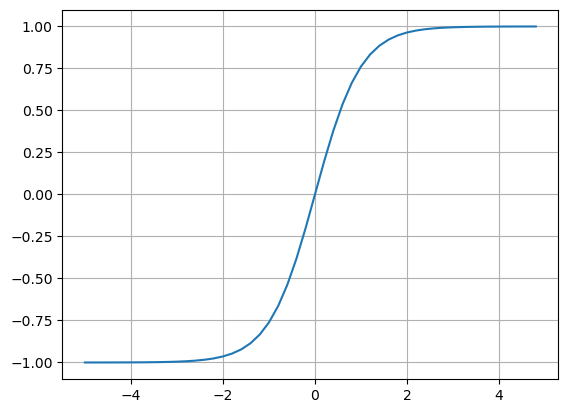

In [10]:
####################################
# 
# Squashing Function Example (tanh)
#
####################################

# https://en.wikipedia.org/wiki/Hyperbolic_functions

import numpy as np
import matplotlib.pyplot as plt
# Outputs get squashed on the y-axis
# As you go more positive from 0 on the input the output rapidly approaches 1 and plateaus there
# As you go more negative from 0 the output squashes and plateaus to -1

### tanh ###
x = np.arange(-5,5,0.2)
y = np.tanh(x)

plt.plot(x,y)
plt.grid()
plt.show()


In [11]:
########### More Advanced Neural Network Expression ############
#
#               USING AUTOMATED BACK PROPAGATION
#
################################################################

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# neuron processing: multiply sets of input/weights and add bias -> x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' # squashing function at end of neuron processing


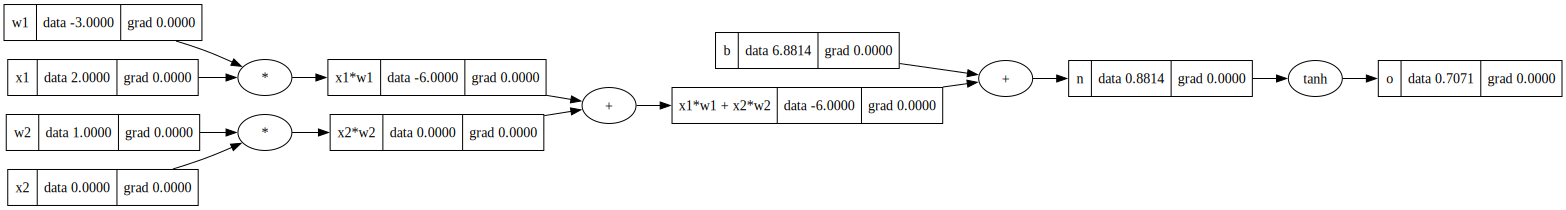

In [12]:
draw_dot(o)
# All gradients start at 0

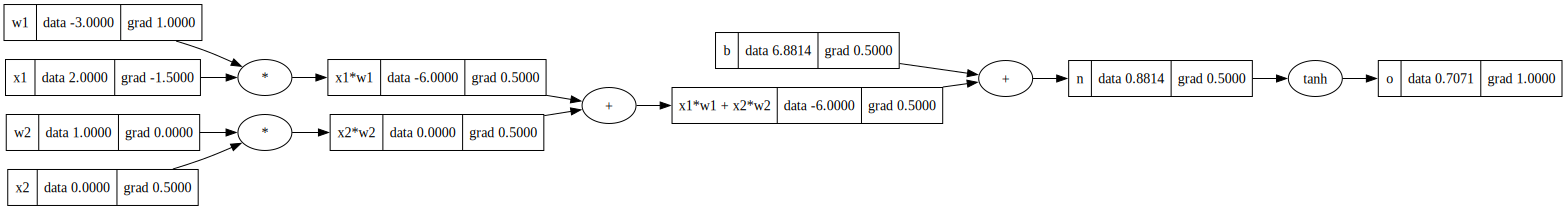

In [13]:
# Call back propagation implementation (_backward()) in the right order

# initialize the first gradient to 1.0 since it is 0.0 to start in the Value class
o.grad = 1.0 # this is the gradient of the final output which is always 1.0

# Start calling _backward which chains the gradients using the chain rule to begin back propagation starting from the end output value:
o._backward() # sets grad for o with respect to n to 0.5
n._backward() # since n is a addition it just passes the gradient from o back (.5)
b._backward() # noop - b (the bias) is a leaf node and its backward() is initialized to an empty function
x1w1x2w2._backward() # grad .5 gets passed again (addition op)
x2w2._backward()
x1w1._backward()

draw_dot(o) # gradients are updated and set - back propagation complete

In [14]:
###########################################################
#
#   Calling Back Propagation using Topological Sort
#
############################################################

# We can't call backwards propagation methods until the expression has been calculated completely
# use Topological sort to order the graph nodes from left to right and call back propagation method on the reversed list

o.grad = 1.0
# This lays out a list of all the nodes in the graph from left to right (o the final output is the last node in the list)
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v) # mark as visited
        for child in v._prev: # iterate through node's children
            build_topo(child)
        topo.append(v) # AFTER iterating through all children, add self to the main list
        # this gaurantees that the node is added to the list only after all of its children are in the list first
build_topo(o) # start at the end output node `o` of the graph

# for node in reversed(topo):
#     node._backward()

# Now all of this can be hidden in a class method so you can just call o.backward()



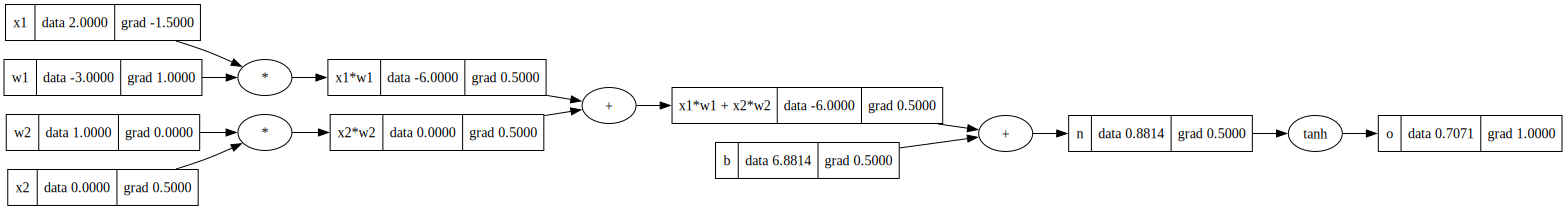

In [15]:
######################################################
#
#   Back Propagation hidden behind class method
#
#######################################################

###### Reset Inputs and weights ######

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# neuron processing: multiply sets of input/weights and add bias -> x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' # squashing function at end of neuron processing


o.backward() # <- single method hiding topological sort and calling back propagation to chain gradients in the graph

draw_dot(o)

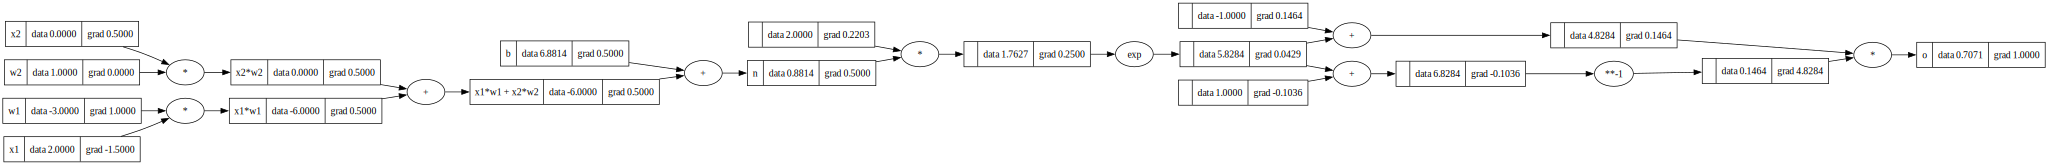

In [16]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

# neuron processing
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ---- implement tanh manually using the exponentiation feature.
# This breaks up tanh into more operations. The op is mathematically equivalent to using `o = n.tanh()`, so we should see the same gradients in back prop as before
#  formula: e^2x - 1 / e^2x + 1 = tanh
e = (2*n).exp() # e^2x
o = (e - 1) / (e + 1)
# ----

o.label = 'o'

o.backward()
draw_dot(o) # verify that the gradients are the same as before

# The main point shown here is that the expressions can be as complicated or as simple as you want.
# The important thing is that you have a chain rule of backwards gradients

In [17]:
###################################################
#
#                 USING PYTORCH
#  (Implementing the same expression using torch)
#
###################################################

import torch

# Everything is based around tensors in pytorch (tensors are n-dimensional arrays of Scalar values)
# Here we have just a single scalar in a tensor, but in practice you'd use multi-dimensional tensors with more rows/cols
# The advantage of using Pytorch is that you get more efficiency and can do operation in parallel with tensors



### Inputs and Weights, Bias ###

x1 = torch.tensor([2.0]).double() # by default tensor dtypes are float32, but python uses doubles by default, so we make everything doubles to be identical and have float64, instead of single precision (float32), like in python
x1.requires_grad=True # because these are leaf nodes (one val), pytorch by default assumes they don't require gradients, so we explicity require them
# (usually you don't compute gradients for leaf nodes like the inputs to the network, so it is False for efficiency reasons)

x2 = torch.tensor([0.0]).double()
x2.requires_grad=True

w1 = torch.tensor([-3.0]).double()
w1.requires_grad=True

w2 = torch.tensor([1.0]).double()
w2.requires_grad=True

b = torch.tensor([6.8813735870195432]).double()
b.requires_grad=True

### Neuron Processing ###

n = x1*w1 + x2*w2 + b # inputs * weights + bias
o = torch.tanh(n) # Activation function

print(o.data.item())

### Run Back Propagation with pytorch's builtin method ###
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

# This should produce the same results as the previous passes over these values
# compare the gradients of the inputs and weights that are entered into the network which are derived from the builtin torch back propagation method

0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [18]:
###############################################
#
#       Implementing a Neural Network
#
###############################################

# Relies on Value class being initialized in first cell
import random

class Neuron:

    def __init__(self, nin):
        '''`nin` = number of inputs to the Neuron (i.e. dimensions of the Neuron) - determines how many weights to make in the constructor'''
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # create uniform distributed weights based on `nin` amount: ex: nin=3 -> [-.33, .24, .26]
        self.b = Value(random.uniform(-1,1)) # bias to control trigger happiness of the neuron - set a random number

    # Overwrite call which allows you to call an instance like a function and pass in arguments to run this function
    def __call__(self, x):
        '''Forward Pass: weights * inputs + bias. `x` are the inputs from each Neuron in the last layer (its output)'''
        # multiply all the weights and inputs (w,x) pair-wise
        weights_times_inputs = (wi*xi for wi, xi in zip(self.w, x)) # creates list of tuples with each w and x pair
        
        # Note: Python's sum starts with the integer 0 which will cause errors adding the Value instances. We need to specify that the start is a Value object
        activation = sum(weights_times_inputs, start=Value(0.0)) + self.b # dot product of weights and inputs with the bias
        
        out = activation.tanh() # Squashing function (Activation function) - will be a number between -1.0 and 1.0
        return out
    
    def parameters(self):
        '''Returns a list of the parameters (weights and the bias) for this Neuron so we can collect them and adjust them based on gradient information from back propagation'''
        
        return self.w + [self.b] # returns a list (self.w is a list and self.b made into a list concatenates the two into one list)
    
# x = [2.0,3.0]
# number_of_inputs = 2
# n = Neuron(number_of_inputs)
# n(x)

In [19]:
class Layer:

    def __init__(self, nin, nout):
        '''`nin` = number of inputs a neuron has determines how many weights are created in the Neuron ctor, `nout` = number of neurons to make for this Layer'''
        self.neurons = [Neuron(nin) for _ in range(nout)] # make `nout` number of neurons in this layer that accept the number of inputs passed in
    
    def __call__(self, x):
        '''`x` are the inputs from each Neuron in the last layer (their output)'''
        outs = [n(x) for n in self.neurons] # Evaluate each neuron independently with the inputs (will differ due to random initialization for each neuron inputs)
        # will be output numbers between -1 and 1 for each neuron in the layer
        return outs[0] if len(outs) == 1 else outs # Just return the Value if we're in the last output neuron layer (has only one neuron), not wrapped in a list
    
    def parameters(self):
        '''
        Collects a concatenated list of all of the parameters (weights and bias) for each neuron in the Layer.
        Collection makes getting them to adjust easier.
        '''
        # return [p for neuron in self.neurons for p in neuron.parameters()] # alternative nested list comprehension one liner (shorter, but maybe below is easier to understand)
        layer_params = []
        for neuron in self.neurons:
            neuron_params = neuron.parameters()
            layer_params.extend(neuron_params) # keeps adding each neuron's parameters in the list to the master list
        return layer_params

# x = [2.0,3.0]
# n = Layer(2, 3) # 2-dimensional neurons and there are 3 of them in the Layer
# print(n(x))

In [20]:
##### Multi-Layer Perceptron (MLP) #####

class MLP:

    def __init__(self, nin, nouts):
        '''`nin` = number of inputs/dimension of Neurons, `nouts` = list of numbers of neurons in each layer'''
        size = [nin] + nouts # [3] + [4,4,1] -> [3,4,4,1]
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

        # For loop useful for Debugging or stepping through
        # self.layers = []
        # for i in range(len(nouts)):
        #     layer = Layer(size[i], size[i+1]) # first pass: 3,4 second: 4,4, third: 4,1. First size[i] is input layer, next arg for number of neurons
        #     self.layers.append(layer)

    def __call__(self, x):
        '''`x` are the inputs to the first layer (the input layer) of the neural network. On subsequent loops they are fed into each neuron in the registered layers'''
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        '''Collects all of the parameters that can be adjusted (weights and biases) from all neurons in the network'''
        # return [p for layer in self.layers for p in layer.parameters()] # one liner alternative
        all_params = []
        for layer in self.layers:
             layer_params = layer.parameters()
             all_params.extend(layer_params)
        return all_params
    

In [21]:
x = [2.0, 3.0, -1.0] # inputs into the layer of neurons (layer 1 is the input layer, layer 2 is the first set of neurons)
n = MLP(3, [4, 4, 1]) # 3 dimensional neurons (takes 3 inputs), 3 layers with 4 neurons in the first 2 and 1 neuron in the last layer (the output layer) - see neural_net.jpg visualization
model_output = n(x) # the final output is the last output layer (the output of the single neuron at the end)

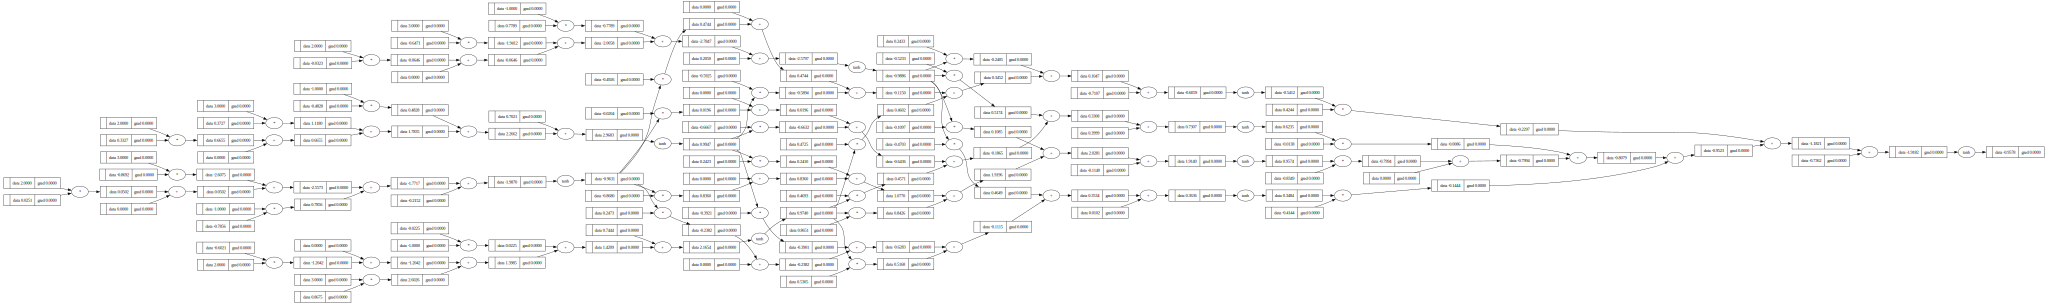

In [22]:
draw_dot(model_output) # initial MLP forward pass - all grads set to 0 to start

In [23]:
n.parameters() # shows all weights and biases (adjustable paremeters) for all the neurons in the network

[Value(data=0.025094120302645573),
 Value(data=-0.8691641123122842),
 Value(data=-0.7855748513974024),
 Value(data=-0.2152270877638509),
 Value(data=0.33272941742950657),
 Value(data=0.3726675344777488),
 Value(data=-0.48277110904625076),
 Value(data=0.7020593816531993),
 Value(data=-0.6020882223537991),
 Value(data=0.8675442923946084),
 Value(data=-0.022457024591192587),
 Value(data=0.7444397989348239),
 Value(data=-0.03230370482404532),
 Value(data=-0.6470539027904014),
 Value(data=0.7789166608350473),
 Value(data=0.20500295369468624),
 Value(data=-0.8680410153549301),
 Value(data=0.2422913534785256),
 Value(data=0.8650518170140049),
 Value(data=-0.10971706077619103),
 Value(data=-0.1140329892769345),
 Value(data=-0.02035794356354681),
 Value(data=-0.6667325564738316),
 Value(data=0.46927992313438827),
 Value(data=-0.5233490515407921),
 Value(data=0.3998758158811364),
 Value(data=0.24734009169376803),
 Value(data=-0.3921194038523199),
 Value(data=0.5305322700252164),
 Value(data=-0.4

In [24]:
####################################
#
#    TUNING THE NEURAL NETWORK
#
####################################

# 4 sets of inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
# Ground Truths: desired output targets corresponding to above inputs - what we want the NN to produce
ys = [1.0, -1.0, -1.0, 1.0] 

def get_predictions(mlp, xs):
    return [mlp(x) for x in xs]

# Get the current output of the Nueral Net given the inputs
n = MLP(3, [4, 4, 1])
ypred = get_predictions(n, xs)
print(ypred)
# Note the outputs and compare to the `ys` target output to see if they are higher or lower than the targets we want
  # Now we want to try to adjust the weights and tune the model so that it gets output closer to our desired targets

# n.layers[0].neurons[0].w[0]

[Value(data=0.4856396424347239), Value(data=0.8564799956801564), Value(data=0.7530453005074778), Value(data=0.020603270329604427)]


In [25]:
##############################################
#    MEASURING QUALITY OF THE MODEL - LOSS 
##############################################

# We use a single number to measure the quality of the NN - the Loss
  # If a model is poor quality it will have a high loss
  # The goal is to minimize the loss number

# Can use the means squared method for a loss function:
# For each prediction, subtract the ground truth from the prediction and square that 
  # If the prediction is close to the target, the difference will be small and the square ensures a positive result and magnifies the further you are off (the loss - how far the prediction was from the target)
  # If the difference is 0, then the prediction matches the target

# Pair the ground truths (the ys targets that represent reality, the right answer) and the predictions of the model
# Take the sum of all of the differences
example_losses = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
print(example_losses)

def calculate_loss(ys, ypred):
    losses = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
    return sum(losses, start=Value(0))

# Take the sum of all of those loss calculations - and that is the total loss
loss = calculate_loss(ys, ypred)
print(f'\nTotal Loss: {loss}')

[Value(data=0.26456657743467865), Value(data=3.446517974360593), Value(data=3.073167825631353), Value(data=0.959217954089066)]

Total Loss: Value(data=7.743470331515691)


In [26]:
print(f'Gradient of weight before backward pass: {n.layers[0].neurons[0].w[0].grad}')

# Call back propagation
  # This includes back propagating across 4 forward passes for each target (4x4) and also the loss on top of that - very long complicated expression graph
  # This way we get the gradients for how the weights all the way towards the beginning of the expression graph relate to the end of the graph at the loss output (the derivative of the Loss with respect to the weight - dL/dw)

loss.backward()

# We now have gradients that were calculated from the backward pass
# If we look at the .grad of a weight on a neuron in the network, we can see whether it is negative or positive and how adjusting it would be impact the loss
  # Example: if the gradient for this weight is negative, then the influence of it (if you increase it) on the loss is also negative - increasing this weight will make the loss go down!
print(f'Gradient of weight (Loss with respect to this weight) after backward pass: {n.layers[0].neurons[0].w[0].grad}')
 
# NOTE: The gradients on the inputs are not important because they are fixed (the inputs are not adjusted because they are not parameters)
  # The important gradients are for the weights and the bias terms - those are the parameters on the model that we can change

Gradient of weight before backward pass: 0.0
Gradient of weight (Loss with respect to this weight) after backward pass: -1.2591132007890582


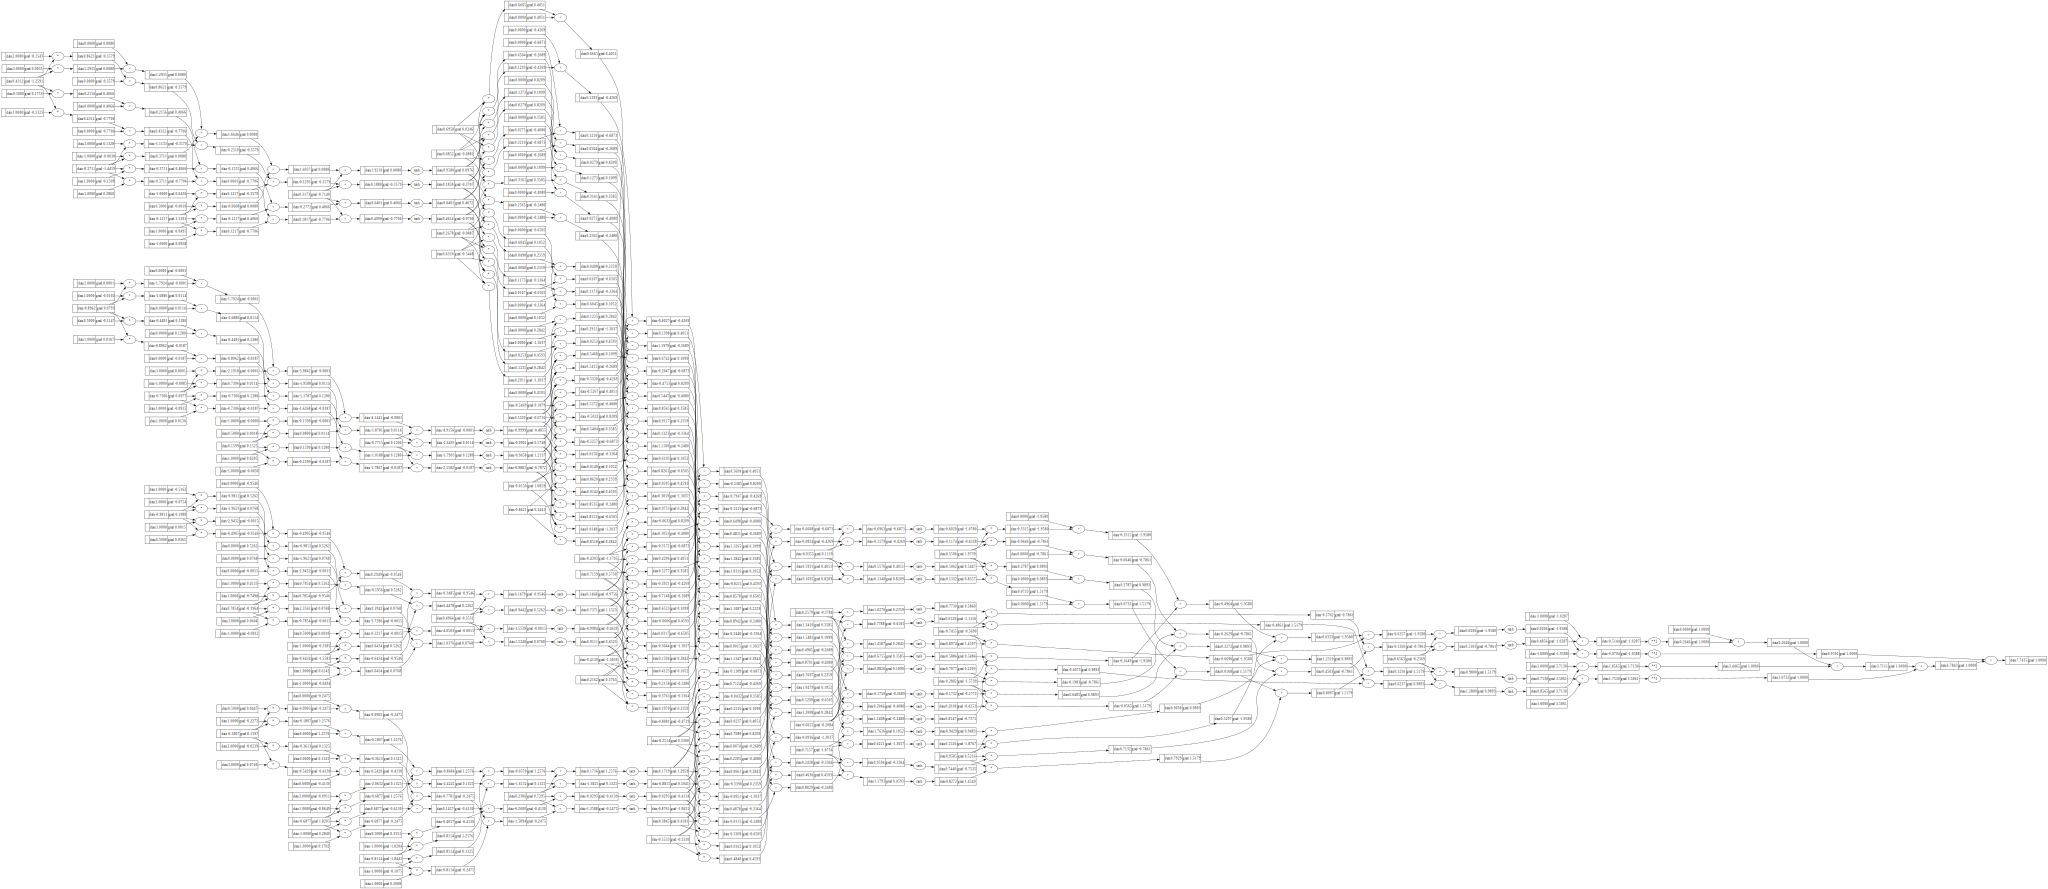

In [27]:
# very  complicated expression graph back propagated against which includes 4 forward passes per target/prediction and the loss calculations on top of it:
draw_dot(loss)

In [28]:
############################################################################################
#                           ADJUST THE PARAMETERS OF THE MODEL
############################################################################################

# GRADIENT DESCENT: the gradient is a vector that points in the direction to move the parameter to increase the loss, so the goal is to move the parameter in the opposite direction to reduce loss (?)
old_weight = n.layers[0].neurons[0].w[0].data
loss_gradient = n.layers[0].neurons[0].w[0].grad
print(f'Gradient of weight (Loss with respect to this weight) after backward pass: {loss_gradient}')
# if this is positive, it means increasing the weight increases the loss, if it is negative, it means increasing the weight decreases the loss (good)

# CAUTION: pay attention to signs - if the weight parameter is negative, and the loss gradient is also negative, if you adjust it by a multiple of a small positive step of the negative gradient you are bringing the parameter DOWN in value which is the opposite of what you want!
    # (Since the loss gradient is negative, it means that you want to INCREASE the parameter to bring the loss further down.)

# If you increase the step size to adjust parameters too much you can overstep and pass the optimal value, but increasing the learning rate can reduce the number of iterations of gradient descent as well and speed up getting the model improved
# Adjusting the learning rate is an art and can be done via trial and error - you want to move towards lowest loss quicker, but not too quick or you will overstep
LEARNING_RATE = -0.01

# Adjust the parameters of the model (n) using a tiny step size in the opposite direction of the loss gradient
for p in n.parameters():
    p.data += LEARNING_RATE * p.grad # adjust the weight by a tiny amount of the gradient. **Make the step size negative** because we want to decrease the loss (flips the sign of the loss gradient because that is a vector pointing in the direction to INCREASE the loss value which we do not want)

Gradient of weight (Loss with respect to this weight) after backward pass: -1.2591132007890582


In [29]:
adjusted_weight = n.layers[0].neurons[0].w[0].data
print(f'Old Weight: {old_weight}')
print(f'Adjusted Weight: {adjusted_weight}')
print(f'Loss gradient: {loss_gradient}')

# The new weight should be adjusted in the OPPOSITE direction of the loss gradient (since we want to decrease loss)
  # If the loss gradient is negative, the new value should be adjusted higher to continue the negative gradient (negative slope) towards a lower loss value
  # If the loss gradient is positive, then the weight should be adjusted lower to go in the opposite direction of the positive effect it has on the loss value

if loss_gradient < 0:
    assert adjusted_weight > old_weight
if loss_gradient > 0:
    assert adjusted_weight < old_weight

Old Weight: 0.4311558873837784
Adjusted Weight: 0.443747019391669
Loss gradient: -1.2591132007890582


In [30]:
########### Verify that the new loss is less after adjustment ####################

print(f'Old Loss: {loss.data}')

# calculate loss after the adjustment of weights (reget the predictions from the model using the adjusted weights now)
new_loss = calculate_loss(ys, get_predictions(n, xs))

print(f'\nNew Loss: {new_loss.data}')

# The new loss should be lower than the old loss which means our predictions are closer to the targets

Old Loss: 7.743470331515691

New Loss: 7.461997877834428


In [31]:
###########################################################
#
#                   GRADIENT DESCENT
#
###########################################################

n = MLP(3, [4, 4, 1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


# The iteration loop on the loss is:
  # Forward pass
  # Backward pass
  # Update the parameters
# The Neural net will continue to improve predictions and reduce loss on each iteration (Gradient Descent)

for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0))

    # need to zero out the grad before doing backward pass on loss each time
    # ? explanation at 2:11:04 at https://www.youtube.com/watch?v=VMj-3S1tku0
    for p in n.parameters():
        p.grad = 0.0
    
    # backward pass
    loss.backward()

    # Update parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(f'Iteration: {k}, Loss: {loss.data}') # Should continue to decrease each iteration

Iteration: 0, Loss: 4.637161506791074
Iteration: 1, Loss: 2.6470500412665405
Iteration: 2, Loss: 1.0704459916265106
Iteration: 3, Loss: 0.5960985024733958
Iteration: 4, Loss: 0.38983497044351123
Iteration: 5, Loss: 0.2792508316954709
Iteration: 6, Loss: 0.21288776202073773
Iteration: 7, Loss: 0.16966965678399779
Iteration: 8, Loss: 0.1397447130290802
Iteration: 9, Loss: 0.11802353799625989
Iteration: 10, Loss: 0.10166068210537144
Iteration: 11, Loss: 0.08896083131115218
Iteration: 12, Loss: 0.07886010646496865
Iteration: 13, Loss: 0.0706615565107143
Iteration: 14, Loss: 0.06389183580018169
Iteration: 15, Loss: 0.05821946104170781
Iteration: 16, Loss: 0.0534061060247565
Iteration: 17, Loss: 0.04927646742808653
Iteration: 18, Loss: 0.045699000137428426
Iteration: 19, Loss: 0.042573242926768916


In [32]:
# When the Loss is as close to 0 as possible or you can get it without overstepping, the predictions should be very close to the targets desired
print(f'Targets: {ys}')
print(f'Predictions: {[pred.data for pred in ypred]}')

Targets: [1.0, -1.0, -1.0, 1.0]
Predictions: [0.950588375822479, -0.9039237228796161, -0.876486183330423, 0.8749183451128437]
